In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data.dataloader import DataLoader
import functools
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torchvision.utils as vutils
import torch.nn.utils.spectral_norm as spectral_norm
from models.DCGAN_Discriminator import Discriminator
from models.DCGAN_Generator import Generator

In [2]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                               transforms.ToTensor(), 
                               transforms.Normalize((0.1307,), (0.3081,))])

In [3]:
dataset = torchvision.datasets.MNIST('./', download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2, drop_last=True)
criterion = nn.BCELoss()


<IPython.core.display.Javascript object>


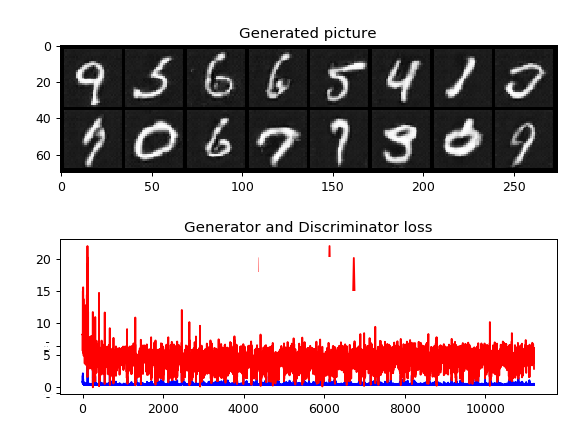

In [4]:
%matplotlib notebook
# Create the training plot
d_current_iteration = 0
d_history = []
d_iteration_number_history = []

g_current_iteration = 0
g_history = []
g_iteration_number_history = []

 
f, (loss_axis, validation_axis) = plt.subplots(2, 1)

loss_axis.plot()
validation_axis.plot(d_iteration_number_history, d_history, 'b',
                    g_iteration_number_history, g_history, 'r')

loss_axis.set_title('Generated picture')
validation_axis.set_title('Generator and Discriminator loss')

plt.tight_layout()

In [6]:
def train_loop(D, G, train_set, num_epochs):
    optimizer1 = torch.optim.Adam(D.parameters(), lr=0.0004, betas=(0.5, 0.999))
    optimizer2 = torch.optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
    d_current_iteration = 0
    d_history = []
    d_iteration_number_history = []

    g_current_iteration = 0
    g_history = []
    g_iteration_number_history = []
    test_noise = torch.randn(16, 100, 1, 1).cuda()
    for epoch in range(num_epochs):
        for i, data in enumerate(data_loader):
            
            optimizer1.zero_grad()
            
            img = data[0].float().cuda()
            batch_size = img.shape[0]
            outputs = D(img).view(-1)
        
            noise = torch.randn(batch_size, 100, 1, 1).cuda()
            real_labels_d = torch.full((batch_size,), 0.9).cuda()
            fake_labels = torch.zeros(batch_size).cuda()
            d_loss_real = criterion(outputs, real_labels_d)
            #d_loss_real.backward()
            
            
            img_gen = G(noise)
            outputs_gen = D(img_gen).view(-1)
        
            
            d_loss_fake = criterion(outputs_gen, fake_labels)
            #d_loss_fake.backward()
            loss = d_loss_fake + d_loss_real
            loss.backward()
            
            d_iteration_number_history.append(d_current_iteration)
            d_history.append(loss)
            d_current_iteration += 1
            
            if i % 100 == 99:
                print('Discriminator loss: ', loss.item())
               
            optimizer1.step()
            
            optimizer2.zero_grad()
            
            real_labels = torch.ones(batch_size).cuda()
            noise = torch.randn(batch_size, 100, 1, 1).cuda()
            img_gen = G(noise)
            outputs_gen = D(img_gen).view(-1)
            loss = criterion(outputs_gen, real_labels)
            loss.backward()
            
            
            g_iteration_number_history.append(d_current_iteration)
            g_history.append(loss)
            g_current_iteration += 1
            
            if i % 100 == 99:
                print('Generator loss: ', loss.item())
            
            optimizer2.step()
            
            validation_axis.lines[0].set_xdata(d_iteration_number_history)
            validation_axis.lines[0].set_ydata(d_history)
            validation_axis.lines[1].set_xdata(g_iteration_number_history)
            validation_axis.lines[1].set_ydata(g_history)
            validation_axis.relim()
            validation_axis.autoscale_view()
            validation_axis.figure.canvas.draw()
            
            if i % 100 == 99:
                with torch.no_grad():
                    G.eval()
                    output = G(test_noise).detach().cpu()
                    output = vutils.make_grid(output, padding=2, normalize=True)
                    loss_axis.imshow(np.transpose(output,(1,2,0)))
                    G.train()
                    loss_axis.relim()
                    loss_axis.autoscale_view()
                    loss_axis.figure.canvas.draw()
            

In [5]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
D = Discriminator(1)
G = Generator(100)
D.apply(init_weights);
G.apply(init_weights);
D.cuda();
G.cuda();
D.train();
G.train();
train_loop(D, G, dataset, 100)

/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Discriminator loss:  0.4628112316131592
Generator loss:  10.090062141418457
Discriminator loss:  0.5193841457366943
Generator loss:  4.8696675300598145
Discriminator loss:  0.5287126302719116
Generator loss:  2.0764455795288086
Discriminator loss:  0.3624964952468872
Generator loss:  5.442292213439941
Discriminator loss:  0.36132267117500305
Generator loss:  6.630489826202393
Discriminator loss:  0.36540594696998596
Generator loss:  5.6762800216674805
Discriminator loss:  0.5795528292655945
Generator loss:  4.031793594360352
Discriminator loss:  0.38073915243148804
Generator loss:  4.443613052368164
Discriminator loss:  0.3430832326412201
Generator loss:  4.306854248046875
Discriminator loss:  0.35753634572029114
Generator loss:  4.431005477905273
Discriminator loss:  0.46883004903793335
Generator loss:  5.582388877868652
Discriminator loss:  0.35935041308403015
Generator loss:  4.992239952087402
Discriminator loss:  0.3522094190120697
Generator loss:  5.490894317626953
Discriminator l

Process Process-11:
Process Process-12:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/dpakho

KeyboardInterrupt: 